In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import io
import copy
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [3]:
save_dir = "/mnt/data/jmarkow/panels/2024-06 (QD paper)"

In [11]:
csv= "/home/jmarkow/data_dir/active_projects/quantum_dots/misc/qdot_spectra/Qdot 800.csv"
led_excel = "/home/jmarkow/data_dir/active_projects/quantum_dots/misc/qdot_spectra/Raw Spectral Distribution Data.xlsx"

In [12]:
df = pd.read_csv(csv).set_index("Wavelength")

In [20]:
lights = {"new_660": "094111",
          "old_730": "095051"}

In [22]:
led_dfs = []
for _light_name, _sheet_name in lights.items():
    _df = pd.read_excel(led_excel, sheet_name=_sheet_name)
    _df["light_name"] = _light_name
    led_dfs.append(_df)

In [26]:
led_df = pd.concat(led_dfs)
led_df = led_df.set_index("Wavelength (nm)")

In [6]:
sns.set_context("paper")

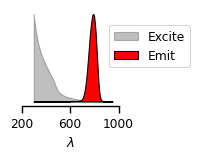

In [7]:
fig, ax = plt.subplots(1, figsize=(1.25,1.25))
ax.fill_between(df.index, df["Excitation"].values, fc="k", ec="k",alpha=.25, label="Excite")
ax.fill_between(df.index, df["Emission"].values, fc="r", ec="k", label="Emit")
ax.legend(bbox_to_anchor=(1.8, .9))
ax.spines[["left", "right", "top"]].set_visible(False)
ax.set_yticks([])
ax.set_xticks([200,600,1000])
ax.set_xlabel("$\lambda$")
fig.savefig(os.path.join(save_dir, "qdot800_spectra_thermo.pdf"), bbox_inches="tight")
# sns.despine(offset=5)


In [29]:
show_lights = ["old_730", "new_660"]

In [46]:
df["Excitation"].index.get_loc(730)

430

In [45]:
df["Excitation"].iloc[361]

2.296627584

In [47]:
df["Excitation"].iloc[430]

0.902534349

In [99]:
new_df = led_df.query("light_name == 'old_730'")
fwhm = new_df.loc[new_df["Relative Irradiance"] > .5].index

In [100]:
edges = (fwhm.min(), fwhm.max())

In [101]:
from scipy import integrate

In [102]:
integrate.trapezoid(df["Excitation"].iloc[np.unique(df["Excitation"].index.get_indexer(fwhm, method="nearest"))])

31.4980458465

In [156]:
vals = led_df.groupby("light_name").idxmax()
idxs = df["Excitation"].index.get_indexer(vals.to_numpy().squeeze(), method="nearest")
yidxs = df["Excitation"].iloc[idxs]

In [174]:
colors = {
    "new_660": [.7, 0, 0],
    "old_730": [1, 0, 0]
}

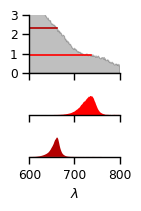

In [175]:
fig, ax = plt.subplots(3, 1, figsize=(1.5,2.2), height_ratios=[3, 1, 1], sharex=True, sharey=False)

ax[0].fill_between(df.index, df["Excitation"].values, fc="k", ec="k",alpha=.25, label="Excite")
for _ax, _light in zip(ax[1:], show_lights):
    plt_df = led_df.query("light_name == @_light")
    _ax.fill_between(plt_df.index, plt_df["Relative Irradiance"] * 100, fc=colors[_light], ec=None)

ax[0].set_ylim(0, 3)
ax[0].set_yticks(np.arange(3.1))
for (_light, _val), _yidx in zip(vals.iterrows(), yidxs):
    ax[0].plot([0, _val.iat[0]], [_yidx] * 2, color=colors[_light])
# ax.legend(bbox_to_anchor=(1.8, .9))
for _ax in ax:
    _ax.spines[["right", "top"]].set_visible(False)
for _ax in ax[1:]:
    _ax.spines["left"].set_visible(False)
    _ax.set_ylim(0, 100)
    _ax.set_yticks([])
    # _ax.set(yticklength=0)
ax[-1].set_xticks(np.arange(500, 801, 100))
ax[-1].set_xlabel("$\lambda$")
ax[-1].set_xlim(600, 800)

fig.tight_layout()
fig.savefig(os.path.join(save_dir, "qdot800_spectra_thermo_excitation_lights_highlighted.pdf"), bbox_inches="tight")

In [ ]:
exp_decay = lambda x, tau: np.exp(-x/tau)

In [ ]:
fig, ax = plt.subplots(1, figsize=(1.25, 1.25))
ax.plot(exp_decay(np.arange(100), 1000), clip_on=False, color="r", lw=1, label="High")
ax.plot(exp_decay(np.arange(100), 100), clip_on=False, color="r", ls="--", lw=1, label="Low")
ax.spines[["top","right"]].set_visible(False)
ax.set_yticks([0,1])
ax.set_ylim(0,1)
ax.set_xticks([0, 100])
ax.set_xlim(0,100)
ax.set_ylim(0,1)
ax.set_xlabel("Time")
ax.set_ylabel("Fluoresence")
ax.legend(bbox_to_anchor=(1.2, .5))
sns.despine(offset=5)
fig.savefig(os.path.join(save_dir, "qdot_photostability.pdf"), bbox_inches="tight")


In [ ]:
# temporal multiplexing

In [ ]:
# load in metadata file and use to derive schematic...

In [ ]:
import toml

In [ ]:
metadata_fname = "/home/jmarkow/data_dir/active_projects/quantum_dots/timecourse_01/session_20231204114743-438357 (system76-pc)/metadata.toml"

In [ ]:
metadata = toml.load(metadata_fname)

In [ ]:
trigger_hi = np.array(metadata["cli_parameters"]["hw_trigger_pulse_width"]) # reflect then fluo
trigger_lo = np.array(metadata["cli_parameters"]["hw_trigger_pulse_low"])

In [ ]:
trigger_hi

In [ ]:
fs = 5000
samples_hi = {}
samples_lo = {}
samples_hi["reflect"] = np.round(trigger_hi[0] * fs).astype("int")
samples_hi["fluo"] = np.round(trigger_hi[1] * fs).astype("int")
samples_lo["reflect"] = np.round(trigger_lo[0] * fs).astype("int")
samples_lo["fluo"] = np.round(trigger_lo[1] * fs).astype("int")

In [ ]:
# one cycle is hi then lo then other hi + lo
cycles = {}
cycles["reflect"] = []
cycles["reflect"] += [1 for _ in range(samples_hi["reflect"])]
cycles["reflect"] += [0 for _ in range(samples_lo["reflect"])]
cycles["reflect"] += [0 for _ in range(samples_lo["fluo"] + samples_hi["fluo"])]


In [ ]:
cycles["fluo"] = []
cycles["fluo"] += [0 for _ in range(samples_lo["reflect"] + samples_hi["reflect"])]
cycles["fluo"] += [1 for _ in range(samples_hi["fluo"])]
cycles["fluo"] += [0 for _ in range(samples_lo["fluo"])]

In [ ]:
ncycles = 7

In [ ]:
plt_fluo = cycles["fluo"] * ncycles
plt_reflect = cycles["reflect"] * ncycles


In [ ]:
fig, ax = plt.subplots(2,1, figsize=(1.25,1))
ax[1].step(np.arange(len(plt_fluo)), plt_fluo, color=[.5, 0, 0], lw=.5)
ax[0].step(np.arange(len(plt_fluo)), plt_reflect, color=[1, 0, 0], lw=.5)
for _ax in ax:
    _ax.axis("off")
fig.savefig(os.path.join(save_dir, "multiplex_schematic.pdf"), bbox_inches="tight")


In [ ]:
samples_hi